## Installing the Transformers and Datasets libraries

In [ ]:
!pip install datasets transformers[sentencepiece]

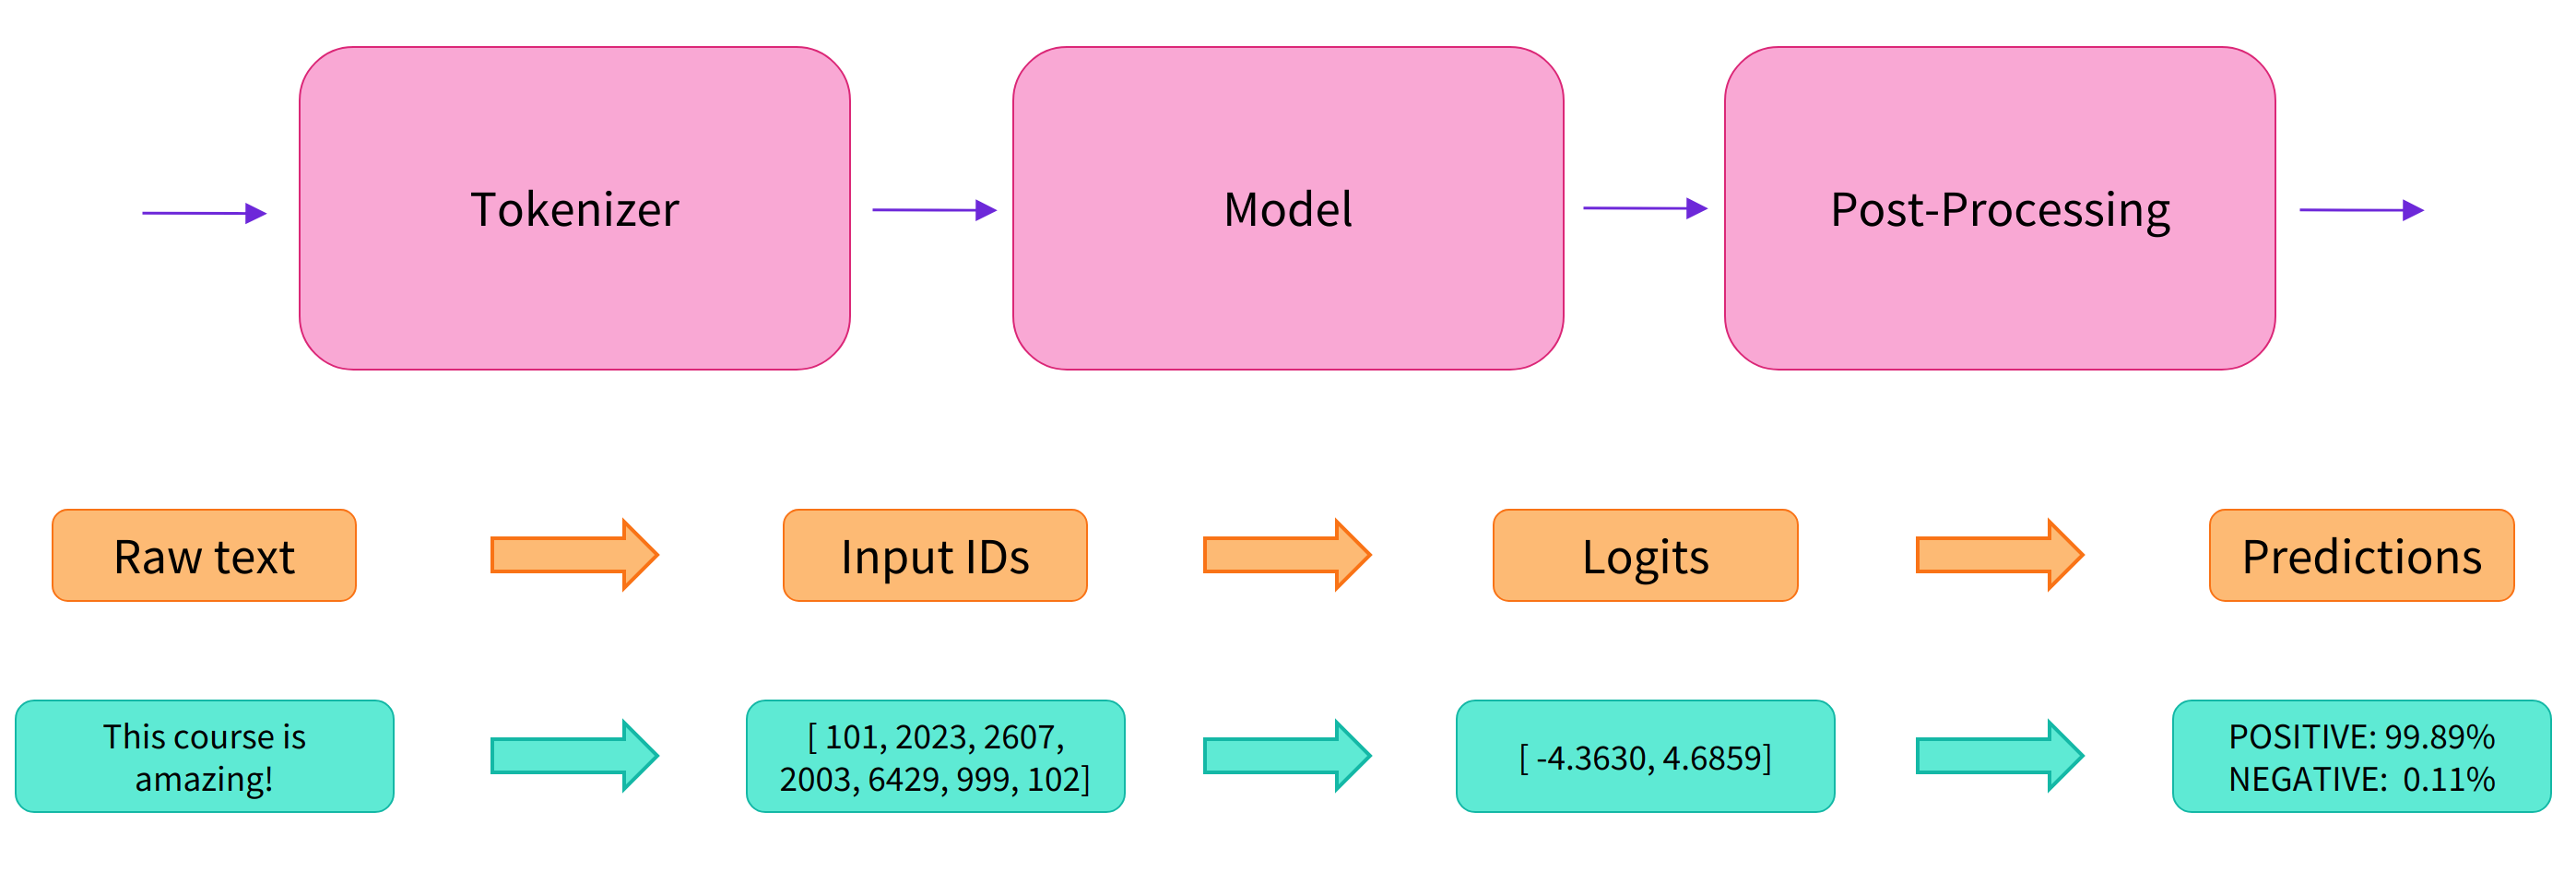

## Sentiment Analysis Using the piepeline API

In [3]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier([
    "I never ever feel afraid of taking risks", 
    "I hate this so much!",
])

[{'label': 'POSITIVE', 'score': 0.9994397163391113},
 {'label': 'NEGATIVE', 'score': 0.9994558095932007}]

## Sentiment Analysis without using the piepeline API

#### Tokenization

In [4]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # is a checkpoint of distilbert-base-uncased, we're basically importing the pretrained weights
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [5]:
raw_inputs = [
    "I never ever feel afraid of taking risks", 
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[  101,  1045,  2196,  2412,  2514,  4452,  1997,  2635, 10831,
          102],
       [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,
            0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32)>}


#### Importing the model checkpoint and building the model with TFAutomodel class

In [6]:
from transformers import TFAutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModel.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head

The different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

In [7]:
outputs = model(inputs)
print(outputs.last_hidden_state.shape) # Batch size,Sequence length, Hidden size: The vector dimension of each model input.

(2, 10, 768)


In [9]:
outputs['last_hidden_state'].shape

TensorShape([2, 10, 768])

- The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers

- The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

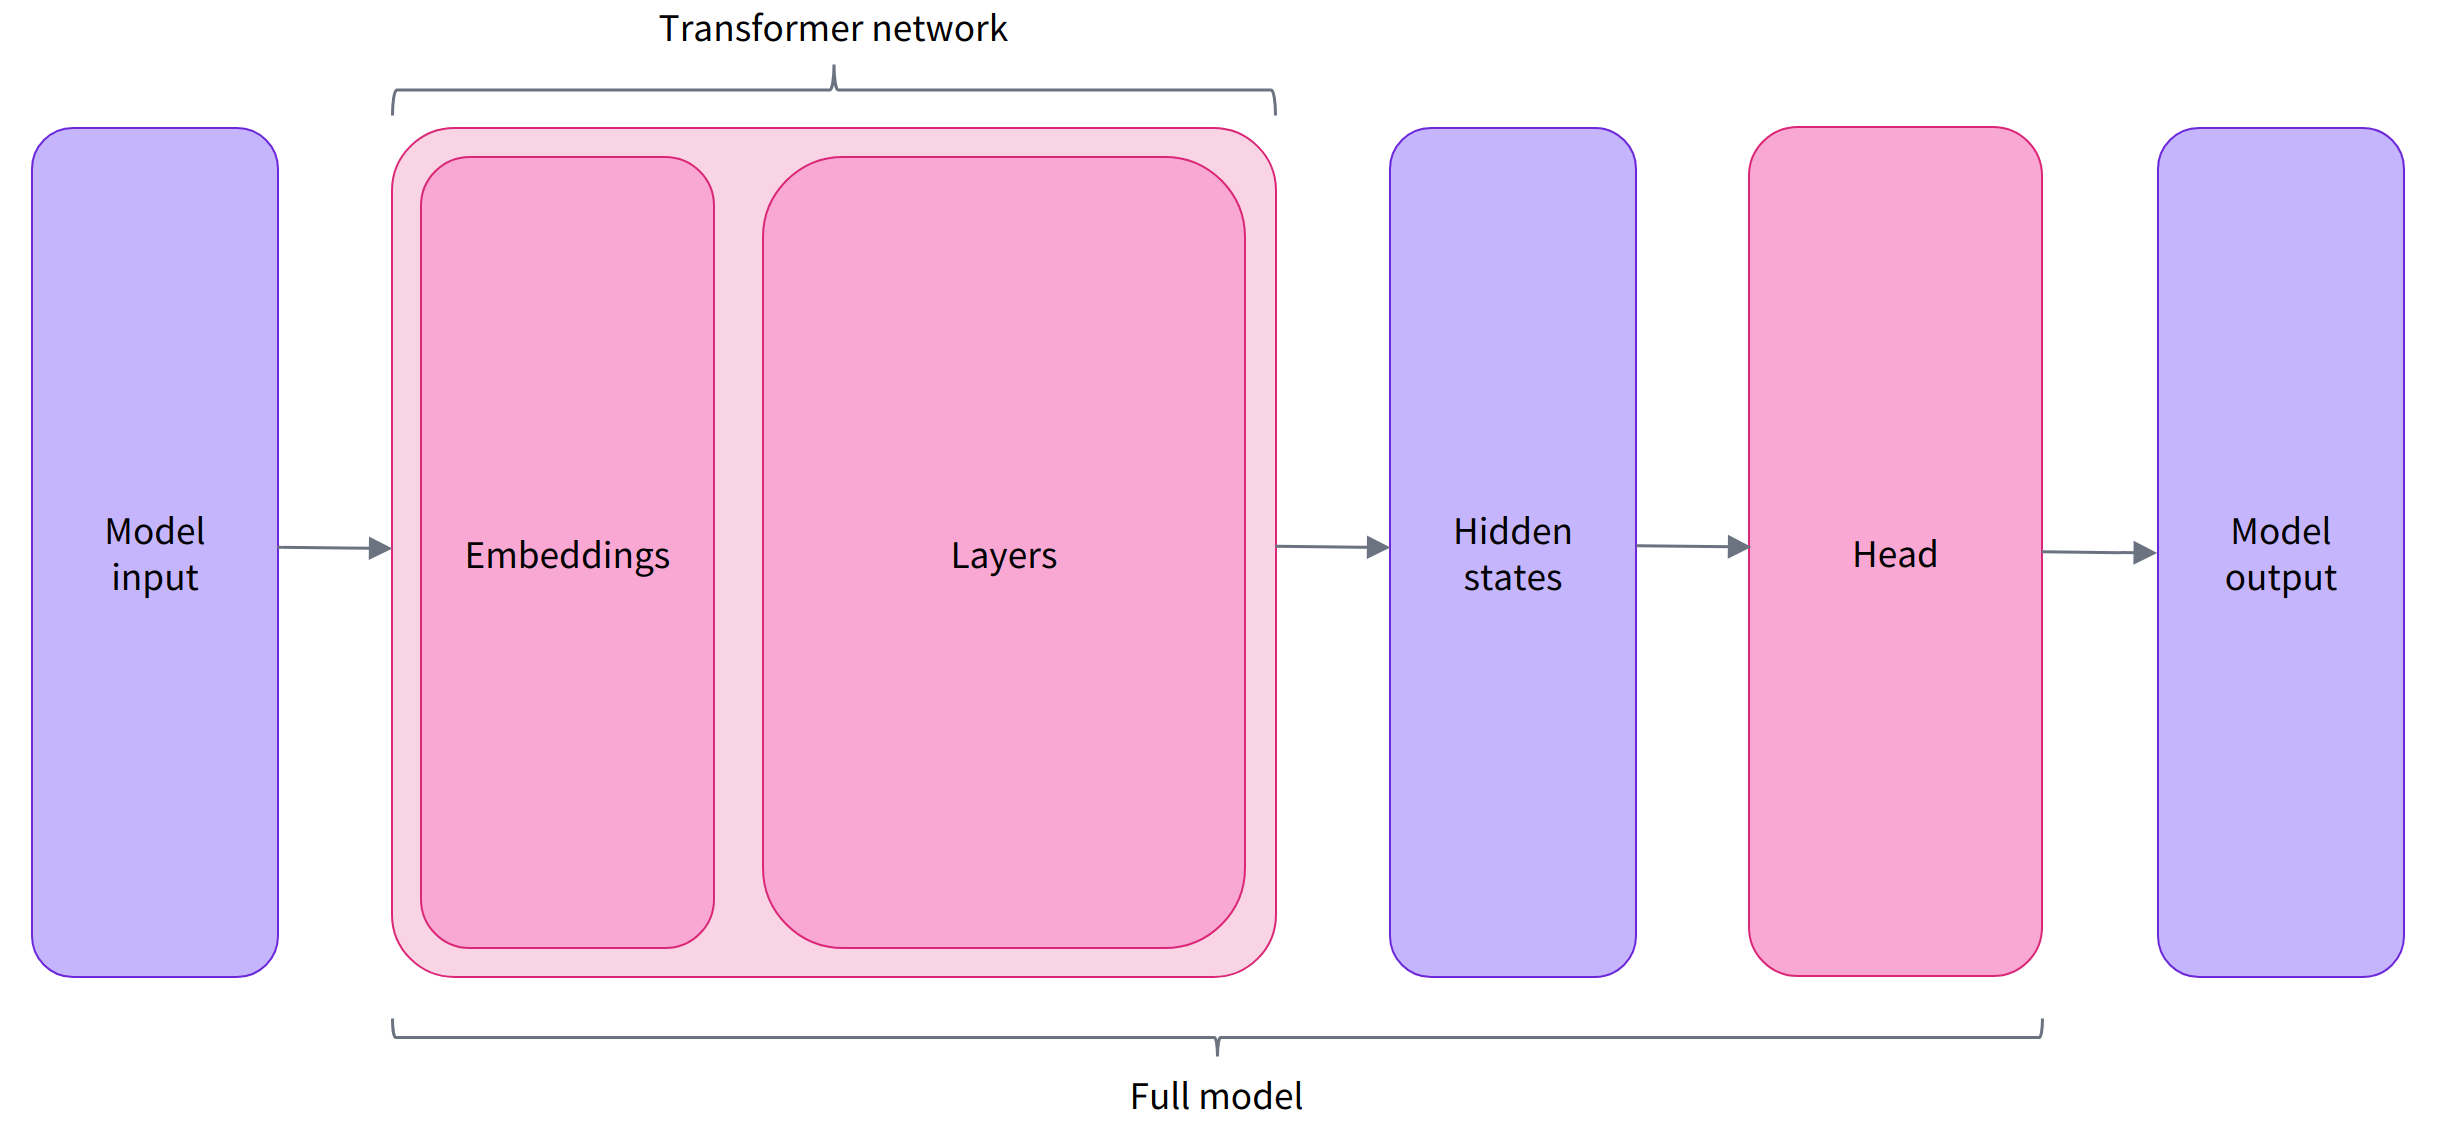

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

*Model (retrieve the hidden states)

*ForCausalLM

*ForMaskedLM

*ForMultipleChoice

*ForQuestionAnswering

*ForSequenceClassification

*ForTokenClassification

and others 🤗

Here for our senetiment analysis(sequence classification) task we'll use  TFAutoModel*ForSequenceClassification

#### Importing the head specific for our use case i.e. sentiment analysis

In [10]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(inputs)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
print(outputs.logits.shape) # output from the head

(2, 2)


In [14]:
print(outputs.logits) # output from the head (not probabilities but logits)

tf.Tensor(
[[-3.6497896  3.8367522]
 [ 4.1692314 -3.3464475]], shape=(2, 2), dtype=float32)


all Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy

Next we covert the logits outputted by the head into normalized probabilities

#### Post processing the model's output

In [15]:
import tensorflow as tf

predictions = tf.math.softmax(outputs.logits, axis=-1)
print(predictions)

tf.Tensor(
[[5.6026422e-04 9.9943978e-01]
 [9.9945587e-01 5.4418400e-04]], shape=(2, 2), dtype=float32)


To get the labels into positive & negative format

In [16]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}